# Lab 4: Convolutional Neural Networks
When your input is shaped "like a grid" (think of audio as a 1-D grid, images as a 2-D grid, 3-D scans, ...), there's a good chance it has _local structure_: points closer in the grid are more related to each other than they are to points further away.
In images, for example, small patterns of nearby pixels can form simple patterns like edges or corners, or more complex patterns like faces.
Pixels in the upper-left of an image are almost unrelated to pixels in the bottom-right corner, except that they're part of the same image.

Another observation is that these local patterns can show up anywhere in the image.
If you're trying to detect faces, it doesn't really matter where they are in the input.
This suggests that we should use the same structure to detect a given pattern everywhere in an image.

Convolutions let us take advantage of both of these observations.
Instead of connecting every part of the input to every part of the output in the same way, as dense layers do, convolutional layers learn small filters which recognize local patterns and "slide" them around the input.

# Convolutions
The heart of convolutional layers is an operation called "discrete convolution" which formalizes how we "slide filters around the grid."

## What does "like a grid" mean?
What this really means is that the input data has some kind of _ordering_ along at least one of its axes.
128x128-pixel color images will be represented by tensors of shape [128, 128, 3] -- the first two axes refer to the pixel, and the third picks an RGB **channel**.
The channel axis (also sometimes called the depth axis) is not ordered, since red is no closer to green than it is to blue.
But the first two axes are ordered: pixel (1, 1) is closer to pixel (1, 2) than it is to (1, 3) or (3, 3).

Convolutional layers are designed to take advantage of this ordering, by assuming that points that are close on ordered axes are more related than points that are further away.
Convolutions will only act on the ordered axes.

## Kernels
Instead of a set of dense weights, convolutional layers learn a set of **kernels**, which are formatted like small patches of grid.
In 1-D, they're 1-dimensional grid segments, in 2-D they're little squares, and in 3-D they're volumes.

To compute the **activation** of a kernel in a particular location in the grid, place the kernel centered there, then compute the dot product of the kernel and the input by multiplying elements that line up and summing the results.

The full result of **convolving** a kernel over an input is the set of activations produced by "sliding" the kernel to all locations on the input, resulting in a grid shaped like the input.
This is often called an **activation map**.

One really important thing to notice here is that _convolution preserves order_.
When you convolve a kernel over an image, the upper-left of the activation map corresponds to the upper-left of the image.
This means that convolutional layers can _preserve local structure_ even as you apply multiple convolutional layers in sequence.
Compare this with dense layers, which connect every output to every input and so lose all ordering information.

Another important property is that convolutions find small local patterns.
You can think of the kernel as a "template".
Its activation on a patch of image indicates how well that image patch matches the template: high positive values mean they have high "similarity" (note that the dot product is not actually normalized), high negative values mean they have similar structure but opposite sign, and values near zero mean that the kernel doesn't structurally match the input there.
These "templates" are applied everywhere on the input, able to match the same pattern (e.g. an edge or a face) again and again.

### 1D
![1-D convolution](https://files.realpython.com/media/njanakiev-1d-convolution.d7afddde2776.png)
(Image source: [Deep Learning with Python](https://realpython.com/asins/1617294438/))

### 2D
![2-D convolution gif](https://cdn-images-1.medium.com/max/1440/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

In this animation, the input image is the blue grid on the left, the output is the teal grid on the right, and the kernel is the square grid of weights
$$\begin{bmatrix}0 & 1 & 2 \\ 2 & 2 & 0 \\ 0 & 1 & 2 \end{bmatrix}$$
The activation at a particular location is shown by shading where the kernel is on the input and the resulting space in the output.

(Image source: ["A guide to convolution arithmetic for deep learning"](https://arxiv.org/abs/1603.07285))

## Filters
Kernels act only on a single channel, and produce a single channel.
When dealing with multi-channel data (like RGB images, or multi-band satellite imagery), the output of a convolutional layer should be based on all of the channels together.
So, instead of using a kernel, we use a **filter**: a collection of kernels, one for each channel in the input's depth axis.

![filter](https://cdn-images-1.medium.com/max/1080/1*lRpx5pTrVewFTD8YXjhIKA.png)

(Image source: ["Intuitively understanding convolutions for deep learning"](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1))

The activation of a filter at a point on an image is the sum of the activations of each of its kernels, applied to one of the channels.
So, each filter takes in a grid of multiple channels and produces a new grid of a single channel (the activation map).

To increase the capacity of a convolutional layer, we use multiple filters in parallel, analogous to the "width" or "number of units" hyperparameter for dense layers.
The activation maps of each filter are concatenated.

So, the first layer of a convolutional neural network (CNN) that operates on 128x128-pixel RGB and uses 64 5x5 filters has the following shapes:
 - Input images have shape [128, 128, 3] (pixel, pixel, channel)
 - Each kernel has shape [5, 5] (pixel, pixel)
 - Each filter has shape [5, 5, 3] (pixel, pixel, channel)
 - Each filter's activation map has shape [128, 128] (pixel, pixel)
 - The output of the layer has shape [128, 128, 64] (pixel, pixel, channel)
(assuming that the layer is padded so the activation maps are still 128x128 pixels)

Note: the next layer's filters would have shape [5, 5, 64] (assuming 5x5 convolutions).
Examples typically come in batches, so you can think of each shape also having a batch axis.
With a batch size of 8, for example, input image batches would have a shape of [8, 128, 128, 3].

For a good visual summary, check out this diagram from ["A guide to convolution arithmetic for deep learning"](https://arxiv.org/abs/1603.07285): 
![multi-channel convolution](./images/convolution_channels.png)

# Convolutional neural networks
Since the outputs of a convolutional layer preserve ordering along ordered axes, and multiple filters result in the output having channels, _the outputs have the same format as the inputs_.
In this case, an input 128x128 image with 3 channels is turned into an output 128x128 image with 64 channels.
This means that we can apply another convolutional layer to the output in order to build deep convolutional neural networks!

Much like when we stack dense layers, early convolutional layers capture simple patterns (like edges, corners, and textures) and later convolutional layers use patterns in those patterns to make higher-level features (like object parts and objects).

![feature hierarchy](./images/feature_hierarchy.png)

(Image source: skymind.ai, ["A Beginner's Guide to Neural Networks and Deep Learning"](https://skymind.ai/wiki/neural-network))

![feature hierarchy 2](http://teleported.in/post_imgs/11-zeiler-fertus.jpg)
(Image source: ["Visualizing and Understanding Convolutional Networks"](https://arxiv.org/abs/1311.2901))

This is great for the "feature extraction" part of a neural network, but how do we use the final activation maps to do classification or regression?
Often, the last activation map is "flattened" into a vector, then fed into a dense layer.
Usually one or two dense layers, followed by an output layer, are sufficient.

For example, if the last convolutional layer of a model is of shape [10, 10, 16], it will be flattened to a vector of shape [10 * 10 * 16] = [1600].
Then, every unit in the first dense layer will have 1600 inputs.

# Interpreting convolutional layers
Like dense layers, convolutional layers have lots of interpretations.

## Learning filters
The idea of convolving filters over images didn't originate with machine learning.
In signal processing and image processing, hand-designed kernels are common.
For example, hand-designed kernels exist for smoothing, sharpening, and edge detection on images.

![filters](./images/filters.png)

(Image source: https://en.wikipedia.org/wiki/Kernel_(image_processing))

Convolutional layers can be interpreted as learning filters of this sort that produce useful features when convolved over images.

## A variant of dense layers
Mathematically, convolutional layers are equivalent to dense layers with two very important constraints:
 - Many of the values are set to zero. This corresponds to the property that the pattern a kernel matches is local: it's based on a small number of adjacent inputs, and the weights connecting those inputs to other (non-local) outputs are zero.
 - The same weights are repeated many times in a fixed pattern. This corresponds to the property that the same kernel is applied many times on the same input.

For instance, a dense layer acting on a 4x4 image to produce a 2x2 image requires (4\*4) \* (2\*2) = 64 weights, arranged in a 4x16 matrix (taking in a 16-vector and producing a 4-vector through affine transformation):
![dense layer](https://cdn-images-1.medium.com/max/1800/1*Nq-Za2-OzW8J5n7Tu7QIWw.png)

However, a 3x3 kernel $K$ acting on this image just requires 3\*3 = 9 weights.

$$K = \begin{bmatrix}k_{1,1} & k_{1,2} & k_{1 ,3} \\ k_{2,1} & k_{2,2} & k_{2 ,3} \\ k_{3,1} & k_{3,2} & k_{3 ,3} \end{bmatrix}$$

Convolving this kernel with the input can be represented as multiplying by a specific 4x16 matrix:
![convolution as a dense layer](https://cdn-images-1.medium.com/max/1800/1*cr0IabpKu4zIyvDgCTQ64A.png)

(Source of images: ["Intuitively Understanding Convolutions for Deep Learning"](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1))

These properties lead to the interpretation of convolutions as dense layers with three very strong priors:
 - Patterns are purely local. This is also called the property of having "sparse interactions." This vastly reduces the number of parameters a layer has, making convolutional layers much faster to run and train, as well as being vastly more statistically efficient (easy to learn well with the available data).
 - Parameters are shared throughout the layer (called "weight sharing" or "weight tying"). This is the prior that the same pattern can appear anywhere in an input.
 - The activation map should be **equivariant** with respect to translation. That means that if something is shifted in an image, the resulting activation is shifted by the same amount in the activation map. 

These priors work extremely well in practice on images and other kinds of grid-shaped data, including many kinds of time-series data (such as speech waveforms).

## Modules / functions
One interpretation of the value of weight sharing is that it corresponds to using the same neuron or group of neurons many places in the input like a programmer might write a function and use it many times in a program.

From this perspective, forcing the network to apply the same group of neurons multiple times forces it to learn representations that are useful in many ways, leading to robust representation.
If the prior that these "functions" are a good fit for the input is accurate, then learning one function and applying it many times is much easier than learning the function many times, once in each place it could be applied.
In practice this seems to be the case.

![modular conv net](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/img/Conv-9-Conv2Conv2.png)

In the image above, taken from Chris Olah's ["Conv Nets: A Modular Perspective"](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/), the network:
 1. Applies a learned function, A, to every point on the input
 2. Applies a second learned function, B, to the outputs of A
 3. Feeds the outputs of B into a dense layer F, which produces the output.
In this view, F is like a large "block of code", kind of like a `main()` function, that chooses how to apply the functions A and B by deciding which of their activations on the input are important and how to use them.

If you'd like to read more about this view, check out the blog post linked above.

# Output size, padding, receptive field, and stride
Note: throughout this box, the animations used have the input on the bottom (blue) and the output on top (teal).
Source: https://github.com/vdumoulin/conv_arithmetic.

## Output size
Because you can't center the kernel on the edge of the image, the output of a convolution will be slightly smaller than the input:
![convolution without padding](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)
This effect gets more significant with larger kernel sizes.

## Padding
However, it's common in many cases to pad the edges of the input so that the output and input have the same dimensions:

![same padding](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif)

This is called "same padding," and sometimes not padding the input is called "valid padding" or "valid convolution" (because you only place the kernel on the input where it's "valid").
Usually the input is padded with zeroes (this is the only kind of padding Keras supports), though [there are some issues with this](https://twitter.com/karpathy/status/720622989289644033?lang=en).
Sometimes "border reflection" is used instead.
Zero-padding usually works fine in practice, though.

Same padding is useful for a few reasons:
 - It enables deeper networks by preventing shrinkage. Even losing 2 pixels at the boundary per layer can be a big deal for deep networks operating on low-resolution inputs.
 - It prevents the model from losing information at the edges.
 - It enables more advanced architectures like Inception to use multiple different sizes of kernels within the same layer, since their outputs will all have the same size.

## Receptive field
An important quantity to think about when designing convolutional networks is **receptive field**.
The receptive field of a pixel in an activation map is the set of pixels in the input image that contributed to making that activation.
For example, the receptive field of a first-layer 3x3 convolution is 3x3 (said to have a "receptive field size of 3"), and the receptive field of a second-layer 3x3 convolution based on that is 5x5.
Activations which are based on the entire image are said to have a "full receptive field." 

Receptive field is important because it constrains what the network could theoretically learn.
No matter how much data you have or how powerful your model, a 1-D convolutional network on audio won't be able to transcribe (word-by-word) a full audio clip if its output units don't have receptive field big enough to encompass an entire word.

Note:
 - Not every input in the receptive field contributes equally to the output. There is the concept of an ["effective receptive field"](http://www.cs.toronto.edu/~wenjie/papers/nips16/top.pdf) which is much smaller than the theoretical receptive field.
 - Just because a model's receptive field theoretically enables it to learn a task doesn't mean it necessarily will. Always consider whether you have enough model capacity to carry out the task and if you have enough data for the capacity.

## Stride
A common modification is **strided convolution**, which moves the kernel more than one space per step, effectively skipping steps in order to intentionally reduce the output size:
![strided convolution](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif)

This is equivalent to _downsampling_ the output, performing a normal convolution and then discarding every other pixel (in the case where stride=2).
Reducing the output size is useful for the internal "feature extraction" layers of a CNN, since it makes training and running the network dramatically cheaper by reducing the number of times we must slide the kernel.
Strided convolution also increases the receptive field out the output significantly.

The cost is that the features become less precisely localized, since we're discarding some of the fine-grained position.

#### Aside: other kinds of convolutions
There are a number of different varieties of convolution that have been developed recently, and are useful in certain situations.
Transposed convolution, dilated convolution, separable convolution, and global average pooling are all important ideas in some modern convolutional networks.

For more info, you might want to skim through ["A guide to convolution arithmetic for deep learning"](https://arxiv.org/abs/1603.07285) or play around with a [receptive field and output size calculator](https://fomoro.com/projects/project/receptive-field-calculator).

# Pooling
**Pooling** is an operation very commonly used in convolutional networks.
Pooling acts on the activation of a layer by "grouping together" nearby values; the most common variety is **max pooling**, which replaces every $n \times n$ square in the activation map with the maximum activation value in that square.
Pooling can be thought of as a sliding-window operation, much like convolution, that uses some other function instead of the linear combination function used by convolution.

![maxpooling](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)
(Source: [Computer Science Wiki](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling))

Much like striding, pooling reduces the dimensionality of the output and increases receptive field size.
More importantly, though, it makes the output _invariant to small translations_: when you shift the input a little, the output doesn't change at all.
This makes pooling appropriate when you care more about _whether a feature is present_ than _exactly where it is_.

# Common architecture choices
Deep convolutional networks follow some common design patterns:
 - First do "feature extraction" with stacked convolutional layers, then flatten and use 1-2 dense layers before the output layer. This allows the network to take advantage of the benefits of convolutional layers to build high-level features, then process those high-level features for a bit once locality isn't so important.
 - Downsample early in the network with strides and max pooling to make the process of feature generation cheaper and increase receptive field size. As features get higher-level, their exact spatial location matters less than whether they're present or not. At the point where locality doesn't matter at all, switch to dense layers.
 - Later layers should have more filters. This increases the channel dimensions of the activation map, allowing the network to propagate information even as the spatial dimension drops. From just a few low-level features (edges, ...) repeated many times in hierarchy, the network can learn many different high-level patterns, and needs one filter for each.
 
A good example of a "normal" CNN is VGG-16:
![vgg-16](https://alexisbcook.github.io/assets/vgg16.png)
(Source: ["Global Average Pooling Layers for Object Localization"](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/))

Note how after each block of convolutional layers, the network downsamples the image by a factor of 4 with max pooling and doubles the number of channels.
It ends with two 4096-unit dense layers, then an output softmax layer for classification.

An interesting fact is that despite only having three total dense layers, and most of the depth being in convolutional layers, the vast majority of the model's parameters are still in the dense layers because of how parameter-efficient convolutional layers are.

# Convolution in TensorFlow
In TensorFlow, convolution is carried out through the operations [`tf.nn.conv1d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv1d), [`tf.nn.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d), and [`tf.nn.conv3d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv3d).
These functions take an `input` tensor that represents a batch of multi-channel inputs, a `filters` tensor that has axes for both which filter (of the parallel filters) is being applied (the last axis) and for which kernel of the filter (the second-to-last axis) is being applied, and return an activation map tensor of the appropriate shape.

To do max pooling, use [`tf.nn.max_pool()`](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool) regardless of the dimensions. 

See below for an example of how to use these:

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# The first MNIST digit. A 5.
image = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 18, 18, 18, 126, 136, 175, 26, 166, 255, 247, 127, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 30, 36, 94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195, 64, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 49, 238, 253, 253, 253, 253, 253, 253, 253, 253, 251, 93, 82, 82, 56, 39, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 18, 219, 253, 253, 253, 253, 253, 198, 182, 247, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 80, 156, 107, 253, 253, 205, 11, 0, 43, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 1, 154, 253, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 139, 253, 190, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 190, 253, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 241, 225, 160, 108, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 81, 240, 253, 253, 119, 25, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 45, 186, 253, 253, 150, 27, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 93, 252, 253, 187, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 249, 253, 249, 64, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 46, 130, 183, 253, 253, 207, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 148, 229, 253, 253, 253, 250, 182, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 114, 221, 253, 253, 253, 253, 201, 78, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 23, 66, 213, 253, 253, 253, 253, 198, 81, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 18, 171, 219, 253, 253, 253, 253, 195, 80, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 55, 172, 226, 253, 253, 253, 253, 244, 133, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 136, 253, 253, 253, 212, 135, 132, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

# Standardize
image = (image / 128.0) - 1

# The input, with dummy "batch" and "channel" dimensions
inp = np.expand_dims(image, axis=0)
inp = np.expand_dims(inp, axis=-1) 

Image shape: (28, 28)
Input shape: (1, 28, 28, 1)


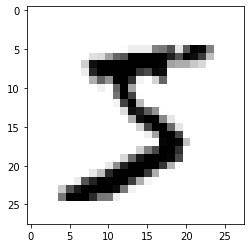

In [3]:
print('Image shape:', image.shape)
print('Input shape:', inp.shape)
plt.imshow(image, cmap='binary')

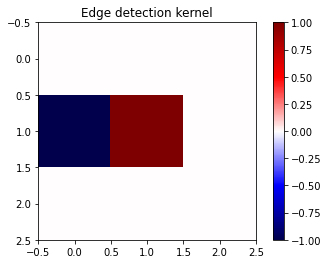

In [4]:
# Define an edge detection kernel
kernel_edge = np.array([[ 0, 0, 0],
                        [-1, 1, 0],
                        [ 0, 0, 0]])

plt.imshow(kernel_edge, cmap='seismic')
plt.title('Edge detection kernel')
plt.colorbar()

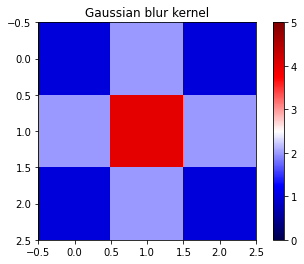

In [5]:
# Define a Gaussian blur kernel
kernel_blur = np.array([[1, 2, 1],
                        [2, 4, 2],
                        [1, 2, 1]])

plt.imshow(kernel_blur, cmap='seismic', vmin=0, vmax=5)
plt.title('Gaussian blur kernel')
plt.colorbar()

In [6]:
# Combine the kernels into two filters, each of shape [3, 3, 1]
filters = np.stack((kernel_edge, kernel_blur), axis=-1)
filters = np.expand_dims(filters, axis=2)
print('Filters tensor shape:', filters.shape) # [3, 3, 1, 2]
# Corresponds to two 3x3 filters, each with 1 kernel

Filters tensor shape: (3, 3, 1, 2)


In [7]:
# Build tiny graph for applying both kernels to the image
inp_tensor = tf.constant(inp, dtype=tf.float64)
filter_tensor = tf.constant(filters, dtype=tf.float64)

# Convolve both filters over the input
activation_tensor = tf.nn.conv2d(
    input=inp_tensor,
    filters=filter_tensor,
    strides=(1, 1, 1, 1), # Stride 1 in each dimension
    padding='VALID')

In [8]:
# Get tensor as a NumPy array
activation = activation_tensor.numpy()
    
# Extract individual activation maps
activation_edge = activation[0, :, :, 0]
activation_blur = activation[0, :, :, 1]

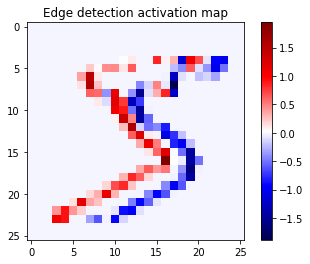

In [9]:
# Show edge-detected activation map
plt.imshow(activation_edge, cmap='seismic')
plt.title('Edge detection activation map')
plt.colorbar()

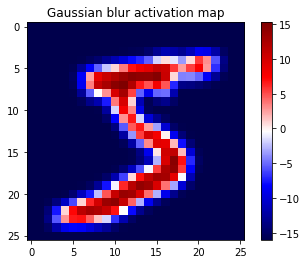

In [10]:
# Show blur activation map
plt.imshow(activation_blur, cmap='seismic')
plt.title('Gaussian blur activation map')
plt.colorbar()

# Convolution in Keras
Convolutional layers are very easy to add in Keras: just use the appropriate layer (usually Conv1D or Conv2D) from [its set of convolutional layers](https://keras.io/layers/convolutional/).
It has a [set of pooling layers too](https://keras.io/layers/pooling/), of which MaxPooling1D and MaxPooling2D are the most common.
To transition from convolutional to dense layers, use keras.layers.Flatten.

The only slightly tricky part of making many common traditional CNNs in Keras is making sure the shapes check out.

# Example: Image CNN with Keras

### Load data

In [11]:
from sklearn.datasets import load_digits

# Load data
dataset = load_digits()

x_all = dataset.data
y_all = dataset.target

# Shuffle some features and targets together
together = np.concatenate([x_all, np.expand_dims(y_all, axis=1)], 
                          axis=1)
np.random.shuffle(together)
x_all = together[:, :-1]
y_all = together[:, -1]

# Split data into train and test sets
n_points = x_all.shape[0]
n_features = x_all.shape[1]
x_all = np.reshape(x_all, (n_points, 8, 8))
x_all = np.expand_dims(x_all, axis=-1)
n_train = int(n_points * 0.7)
n_test = n_points - n_train

print('Input shape:', x_all.shape)
print('Target shape:', y_all.shape)

x_train, x_test = np.split(x_all, [n_train], axis=0)
y_train, y_test = np.split(y_all, [n_train])

Input shape: (1797, 8, 8, 1)
Target shape: (1797,)


Text(0.5, 1.0, 'Label:9.0')

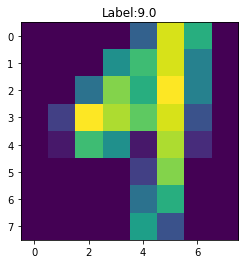

In [12]:
plt.imshow(x_train[0, :, :, 0])
plt.title('Label:' + str(y_train[0]))

### Build a model

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten

model = Sequential()

# First, two 2x2, 16-filter convolutional layers
model.add(Conv2D(filters=16, kernel_size=2,
                 padding='same', activation='relu',
                 input_shape=(8, 8, 1)))
model.add(Conv2D(16, 2, padding='same', 
                 activation='relu'))

# Then, a 2x2 max pooling
model.add(MaxPool2D(pool_size=2))


# Two 2x2, 32-filter convolutional layers
model.add(Conv2D(32, 2, padding='same', 
                 activation='relu'))
model.add(Conv2D(32, 2, padding='same', 
                 activation='relu'))

# Flatten the image into a vector
model.add(Flatten())

# A single dense layer with 300 units
model.add(Dense(300, activation='relu'))

# Output layer, for 10-class classification: 
model.add(Dense(10, activation='softmax'))

### Compile with an optimizer

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 16)          80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          1040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 32)          4128      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               1

In [15]:
from keras.optimizers import SGD

optimizer = SGD(lr=1e-3, momentum=0.9)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [16]:
# Need to one-hot encode the targets
y_train_onehot = keras.utils.to_categorical(y_train, num_classes=10)
y_test_onehot = keras.utils.to_categorical(y_test, num_classes=10)

model.fit(x_train, y_train_onehot,
          epochs=50, batch_size=32,
          validation_data=(x_test, y_test_onehot))

Epoch 1/50
40/40 [==============================] - 0s 8ms/step - loss: 2.1251 - categorical_accuracy: 0.3134 - val_loss: 1.8031 - val_categorical_accuracy: 0.5944
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 1.2979 - categorical_accuracy: 0.6388 - val_loss: 0.8637 - val_categorical_accuracy: 0.7537
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 0.6110 - categorical_accuracy: 0.8186 - val_loss: 0.4759 - val_categorical_accuracy: 0.8630
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 0.4132 - categorical_accuracy: 0.8640 - val_loss: 0.3648 - val_categorical_accuracy: 0.8796
Epoch 5/50
40/40 [==============================] - 0s 5ms/step - loss: 0.2596 - categorical_accuracy: 0.9125 - val_loss: 0.2368 - val_categorical_accuracy: 0.9259
Epoch 6/50
40/40 [==============================] - 0s 5ms/step - loss: 0.2116 - categorical_accuracy: 0.9284 - val_loss: 0.2915 - val_categorical_accuracy: 0.8981
Epoch 7/50
40/40

40/40 [==============================] - 0s 7ms/step - loss: 0.0026 - categorical_accuracy: 1.0000 - val_loss: 0.0681 - val_categorical_accuracy: 0.9815


### Run inference

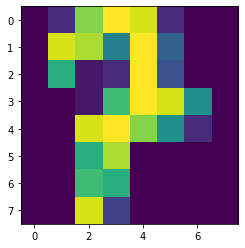

In [17]:
plt.imshow(x_test[0, :, :, 0])

In [18]:
pred = model.predict(np.expand_dims(x_test[0], axis=0), batch_size=1)

print('Predicted probabilities:', pred)
print('Predicted class:', np.argmax(pred))
print('True class label:', y_test[0])

Predicted probabilities: [[1.9780234e-14 4.7421933e-09 7.6515633e-10 1.5335970e-10 8.0228438e-07
  5.4276050e-13 5.7952289e-12 9.9999917e-01 1.4895160e-09 5.7352395e-10]]
Predicted class: 7
True class label: 7.0
